# Import relevant libraries

In [143]:
import os
import copy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup path

In [68]:
# set up paths
base_path = '../datasets'
cleaned_data_path = os.path.join(base_path, 'cleaned_data')

# Load data

In [69]:
node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
perf_eval_df = pd.read_csv(os.path.join(cleaned_data_path, 'perf_eval_table.csv'))

# Analysis

**Thesis Statement:**

Workflow:
1) Step1  
2) Step2  
3) Step3  

**To do**
- There seems to be a trend on age-price so we dev scaling factor (average price by age with base age) to diminish the effect of age on price.
- Identify the effect of homophily (Membership closure) on performance -> performance metric = f(price, scaling_factor) and maybe with combination of other metrics
- Identify the behavior of the transfer if it's related to our analysis,   
  - if yes: the analysis might be the cause  
  - if no: give some recommendation

## Fee-Age Analysis

In [70]:
fee_age = perf_eval_df[perf_eval_df['transfer_movement'] == 'in'][['age', 'fee_cleaned']]
fee_age

,age,fee_cleaned
1,21.0,0.203
3,24.0,4.280
4,25.0,1.350
7,27.0,1.350
9,28.0,2.700
...,...,...
16093,30.0,3.600
16095,26.0,4.730
16097,28.0,4.050
16098,28.0,1.800


<AxesSubplot:xlabel='age', ylabel='fee_cleaned'>

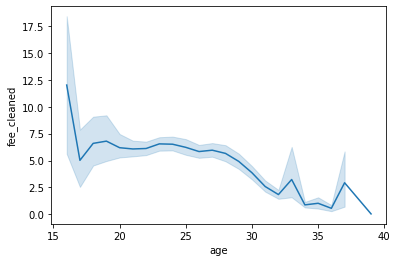

In [71]:
sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned')

In [72]:
# descriptive statistics
desc_stat = fee_age.groupby('age')['fee_cleaned'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
# remove group with small number of observations
desc_stat = desc_stat[desc_stat['count'] > 30]

In [73]:
# There are some outliers that greatly influence the mean and thus using median is more robust
desc_stat

,mean,median,std,min,max,count
age,,,,,,
18.0,6.597215,3.150,9.052794,0.045,36.00,65
19.0,6.805434,2.790,14.677397,0.045,130.50,196
20.0,6.194580,3.565,9.746957,0.023,124.20,348
21.0,6.078661,2.700,8.813119,0.009,72.00,572
22.0,6.121019,3.150,8.364714,0.010,67.50,724
23.0,6.550291,3.150,9.885303,0.019,94.50,877
24.0,6.519200,3.240,9.621015,0.054,90.90,857
25.0,6.227898,2.970,11.156452,0.015,199.80,854
26.0,5.837947,3.150,8.363540,0.045,78.30,830


In [74]:
# downtrend is observed from the age of 29
pd.DataFrame(desc_stat['median'].pct_change()).fillna(0).style.background_gradient(cmap='coolwarm')

,median
age,
18.0,0.000000
19.0,-0.114286
20.0,0.277778
21.0,-0.242637
22.0,0.166667
23.0,0.000000
24.0,0.028571
25.0,-0.083333
26.0,0.060606


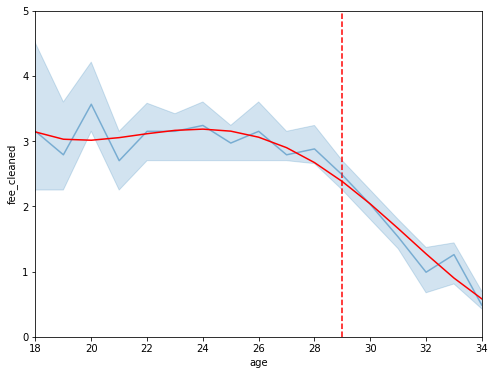

In [75]:
# visualize
fig, ax = plt.subplots(figsize = (8, 6))

sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.median, alpha = 0.5)

xlim = (desc_stat.index[0], desc_stat.index[-1])
ylim = (0, 5)

# add vertical line
plt.vlines(x = 29, ymin = ylim[0], ymax = ylim[1],
           colors = 'red', linestyles = 'dashed')

# fit polynomial to smoothen the trend (for adjustment coefficient)
x = list(desc_stat['median'].index)
y = list(desc_stat['median'])

fit = np.polyfit(x, y, deg = 4)
poly1d = np.poly1d(fit)

# add adjustment line
plt.plot(x, poly1d(x), '-', c = 'red')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [76]:
# develop adjustment coefficient
fitted_value = poly1d(x)

baseline = fitted_value[0]
base_value = np.divide(fitted_value, baseline)
coef = np.reciprocal(base_value)

temp_df = pd.DataFrame(data = {'age': desc_stat['median'].index, 
                               'coef': coef})
temp_df

,age,coef
0,18.0,1.000000
1,19.0,1.036708
2,20.0,1.041973
3,21.0,1.028369
4,22.0,1.008515
5,23.0,0.992200
6,24.0,0.986311
7,25.0,0.996012
8,26.0,1.026201
9,27.0,1.083025


In [77]:
# extend age range to cover the data using lower-upper bound coefficient
age_df = pd.DataFrame(data = {'age': sorted(fee_age['age'].unique())})
adj_coef_table = pd.merge(age_df, temp_df, on = 'age', how = 'left')
adj_coef_table['coef'] = adj_coef_table['coef'].interpolate(method = 'linear', limit_direction = 'both')
adj_coef_table

,age,coef
0,16.0,1.000000
1,17.0,1.000000
2,18.0,1.000000
3,19.0,1.036708
4,20.0,1.041973
5,21.0,1.028369
6,22.0,1.008515
7,23.0,0.992200
8,24.0,0.986311
9,25.0,0.996012


## Homophily-Performance Analysis

In [78]:
node_edge_df.head()

,player_name,age,position,fee,fee_cleaned,year,season,club_name,club_involved_name,transfer_movement,league_name
0,Aapo Halme,21.0,Centre-Back,£203Th.,0.203,2019,2019/2020,Leeds United,Barnsley FC,out,Championship
1,Aapo Halme,21.0,Centre-Back,£203Th.,0.203,2019,2019/2020,Barnsley FC,Leeds,in,Championship
2,Aaron Cresswell,24.0,Left-Back,£4.28m,4.280,2014,2014/2015,Ipswich Town,West Ham,out,Championship
3,Aaron Cresswell,24.0,Left-Back,£4.28m,4.280,2014,2014/2015,West Ham United,Ipswich,in,Premier League
4,Aaron Hughes,25.0,Centre-Back,£1.35m,1.350,2005,2005/2006,Aston Villa,Newcastle,in,Premier League


In [79]:
# summary table
summary_table = pd.pivot_table(data = node_edge_df, 
                              values = 'club_involved_name',
                              index = ['player_name', 'fee', 'fee_cleaned', 'year'],
                              columns = ['transfer_movement'],
                              aggfunc = lambda x: x)
summary_table.sort_values(by = ['player_name', 'year'], inplace = True)

In [80]:
# get column 'num_movement' which represent the number of movement
summary_table['count'] = 1
summary_table['num_movement'] = summary_table.groupby('player_name')['count'].cumcount() + 1
summary_table.drop(columns = 'count', inplace = True)
summary_table.head(10)

transfer_movement                                                    in  \
player_name     fee                     fee_cleaned year                  
Aapo Halme      £203Th.                 0.203       2019          Leeds   
Aaron Cresswell £4.28m                  4.280       2014        Ipswich   
Aaron Hughes    £1.35m                  1.350       2005      Newcastle   
                                                    2007    Aston Villa   
                Free transfer           0.000       2014            QPR   
Aaron Hunt      Free transfer           0.000       2014  Werder Bremen   
                £2.70m                  2.700       2015  VfL Wolfsburg   
Aaron Lennon    £1.08m                  1.080       2005          Leeds   
                End of loanMay 31, 2015 0.000       2014        Everton   
                Loan                    0.000       2014          Spurs   

transfer_movement                                                   out  \
player_name     fee                     fee_cleaned year                  
Aapo Halme      £203Th.                 0.203       2019    Barnsley FC   
Aaron Cresswell £4.28m                  4.280       2014       West Ham   
Aaron Hughes    £1.35m                  1.350       2005    Aston Villa   
                                                    2007         Fulham   
                Free transfer           0.000       2014       Brighton   
Aaron Hunt      Free transfer           0.000       2014  VfL Wolfsburg   
                £2.70m                  2.700       2015   Hamburger SV   
Aaron Lennon    £1.08m                  1.080       2005          Spurs   
                End of loanMay 31, 2015 0.000       2014          Spurs   
                Loan                    0.000       2014        Everton   

transfer_movement                                         num_movement  
player_name     fee                     fee_cleaned year                
Aapo Halme      £203Th.                 0.203       2019             1  
Aaron Cresswell £4.28m                  4.280       2014             1  
Aaron Hughes    £1.35m                  1.350       2005             1  
                                                    2007             2  
                Free transfer           0.000       2014             3  
Aaron Hunt      Free transfer           0.000       2014             1  
                £2.70m                  2.700       2015             2  
Aaron Lennon    £1.08m                  1.080       2005             1  
                End of loanMay 31, 2015 0.000       2014             2  
                Loan                    0.000       2014             3

In [81]:
summary_table.reset_index(inplace = True)
summary_table

transfer_movement,player_name,fee,fee_cleaned,year,in,out,num_movement
0,Aapo Halme,£203Th.,0.203,2019,Leeds,Barnsley FC,1
1,Aaron Cresswell,£4.28m,4.280,2014,Ipswich,West Ham,1
2,Aaron Hughes,£1.35m,1.350,2005,Newcastle,Aston Villa,1
3,Aaron Hughes,£1.35m,1.350,2007,Aston Villa,Fulham,2
4,Aaron Hughes,Free transfer,0.000,2014,QPR,Brighton,3
...,...,...,...,...,...,...,...
26740,Öyvind Leonhardsen,Free transfer,0.000,2002,Spurs,Aston Villa,3
26741,Özgür Aktas,Free transfer,0.000,2020,Vitesse,Fortuna Sittard,1
26742,Ümit Davala,£1.80m,1.800,2002,Milan,Inter,1
26743,Ümit Davala,Loan,0.000,2003,Inter,Werder Bremen,2


In [ ]:
"""
Example of designed nested dictionary  
{ `Year1` : { `Club1` : [Player1, Player2, Player3....],
              `Club2` : [Player1, Player2, Player3....],
                      :
                      :
                      :
        }  
  `Year2` : { `Club1` : [Player1, Player2, Player3....],
              `Club2` : [Player1, Player2, Player3....],
                      :
                      :
                      :
        }
}
"""

In [86]:
# 3 components needed: 'year_list', 'club_list', 'player_list'
year_list = sorted(sorted(node_edge_df['year'].unique()))
club_list = sorted(node_edge_df['club_involved_name'].unique())
# player_list = sorted(node_edge_df['player_name'].unique())

In [148]:
# nested dictionary: year: `club_member`
nested_dict = {}
prev_year = None

# loop over year:
for year in year_list:
    
    if prev_year in nested_dict.keys():
        
        # retrieve club-player info in the previous year for the second year and so on
        club_member = copy.deepcopy(nested_dict[prev_year])
    
    else:
        # initiate a dictionary of clubs (keys) and their affiliated players (values)
        club_member = {}
    
    # subset data by year
    data = node_edge_df[node_edge_df['year'] == year]
    
    # subset for transfer_movement == 'in', 'out'
    data_in = data[data['transfer_movement'] == 'in']
    data_out = data[data['transfer_movement'] == 'out']
        
    # loop over club:
    for club in club_list:
        
        # subset data by club
        temp_data_in = data_in[data_in['club_involved_name'] == club]
        temp_data_out = data_out[data_out['club_involved_name'] == club]
        
        # update all players in that club in the dictionary (`club_member`)
        player_list_in = temp_data_in['player_name'].unique()
        player_list_out = temp_data_out['player_name'].unique()
        
        if prev_year in nested_dict.keys():
            # update club_member info
            club_member[club] = set.union(set(club_member[club]), set(player_list_in)) - set(player_list_out)
            
        else:
            # update club_member info
            club_member[club] = player_list_in
    
    # store `club_member` in `nested_dict`
    nested_dict[year] = club_member
    
    # set previous year
    prev_year = year